# Sistema para compartir bicicletas -Modelo basado en árbol de decisión

+ Basado en datos de [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
+ Este notebook se basa en el archivo de datos por hora, *hour.csv* (renombrado a *MLII - Clase 12 - datos.csv*)

---
Referencia:
Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg,

## Importamos librerías




In [85]:
# manipulación de datos 
import numpy as np
import pandas as pd

# gráficos
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# definición de parámetros
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

# pandas mostrar data frames como tablas
from IPython.display import display, HTML


## Leer datos

In [86]:
# Si se usa Google Colab
from google.colab import files
uploaded = files.upload()




Saving MLII - Clase 12 - datos.csv to MLII - Clase 12 - datos (1).csv


In [87]:
hour_df = pd.read_csv('MLII - Clase 12 - datos.csv')

#hour_df = pd.read_csv('MLII - Clase 12 - datos.csv')

In [88]:


print("Forma del dataset::{}".format(hour_df.shape))

Forma del dataset::(17379, 17)


In [89]:
display(hour_df.head())

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Pre procesamiento
+ Nombre de columnas estándar
+ Cambiar tipo de datos de atributos
+ Transformar variables categoricas usando One Hot Encoding

### Nombre de columnas estándar

In [90]:
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)


## Conversión de tipos de datos

In [91]:
# Conversión a date_time
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# Variables categóricas
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')



### Transformar variables categoricas usando One Hot Encoding

In [92]:
def fit_transform_ohe(df,col_name):
    """Esta función realiza one hot encoding para la
        columna especificada.

    Args:
        df(pandas.DataFrame): el dataframe que contiene el nombre de la columna mencionada
        col_name: la columna a codificar

    Devuelve:
        tupla: codificador_de_etiquetas, codificador_one_hot, columna transformada como Serie pandas

    """
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    # columna one hot
    le = LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# dado el codificador de etiquetas y un objeto one hot encoder, 
# codificar el atributo a ohe
def transform_ohe(df,le,ohe,col_name):
    """Esta función realiza una codificación one hot para la
        columna especificada utilizando los objetos codificadores especificados.

    Args:
        df(pandas.DataFrame): el dataframe que contiene el nombre de la columna mencionada
        le(Label Encoder): el objeto codificador de etiquetas utilizado para ajustar la codificación de etiquetas
        ohe(One Hot Encoder): el objeto one hot encoder utilizado 
        col_name: la columna a codificar

    Devuelve
        tuple: columna transformada como serie pandas

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

## Partición Train-Test

In [93]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}{}".format(X_test.shape, y_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)(5736, 2)


In [94]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']


In [95]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [96]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in cat_attr_list])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [97]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [98]:
X.shape,y.shape

((11643, 19), (11643, 1))

## Regresor Árbol de Decisión


El proceso de entrenamiento de los árboles de decisión es un poco complicado y diferente al de la regresión lineal.
Aunque realizamos una validación cruzada mientras entrenábamos nuestro modelo de regresión lineal, no teníamos ningún hiperparámetro que ajustar. En el caso de los árboles de decisión, tenemos un buen puñado de ellos. 

Antes de entrar en los detalles de la obtención de hiperparámetros óptimos, veremos el DecisionTreeRegressor del módulo de árboles de sklearn, 
instanciando un objeto regressor con algunos de los hiperparámetros establecidos de la siguiente manera.

In [99]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_split=5)

In [100]:
dtr.score(X,y)

0.5645919317952333

### Mostrar el modelo entrenado


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


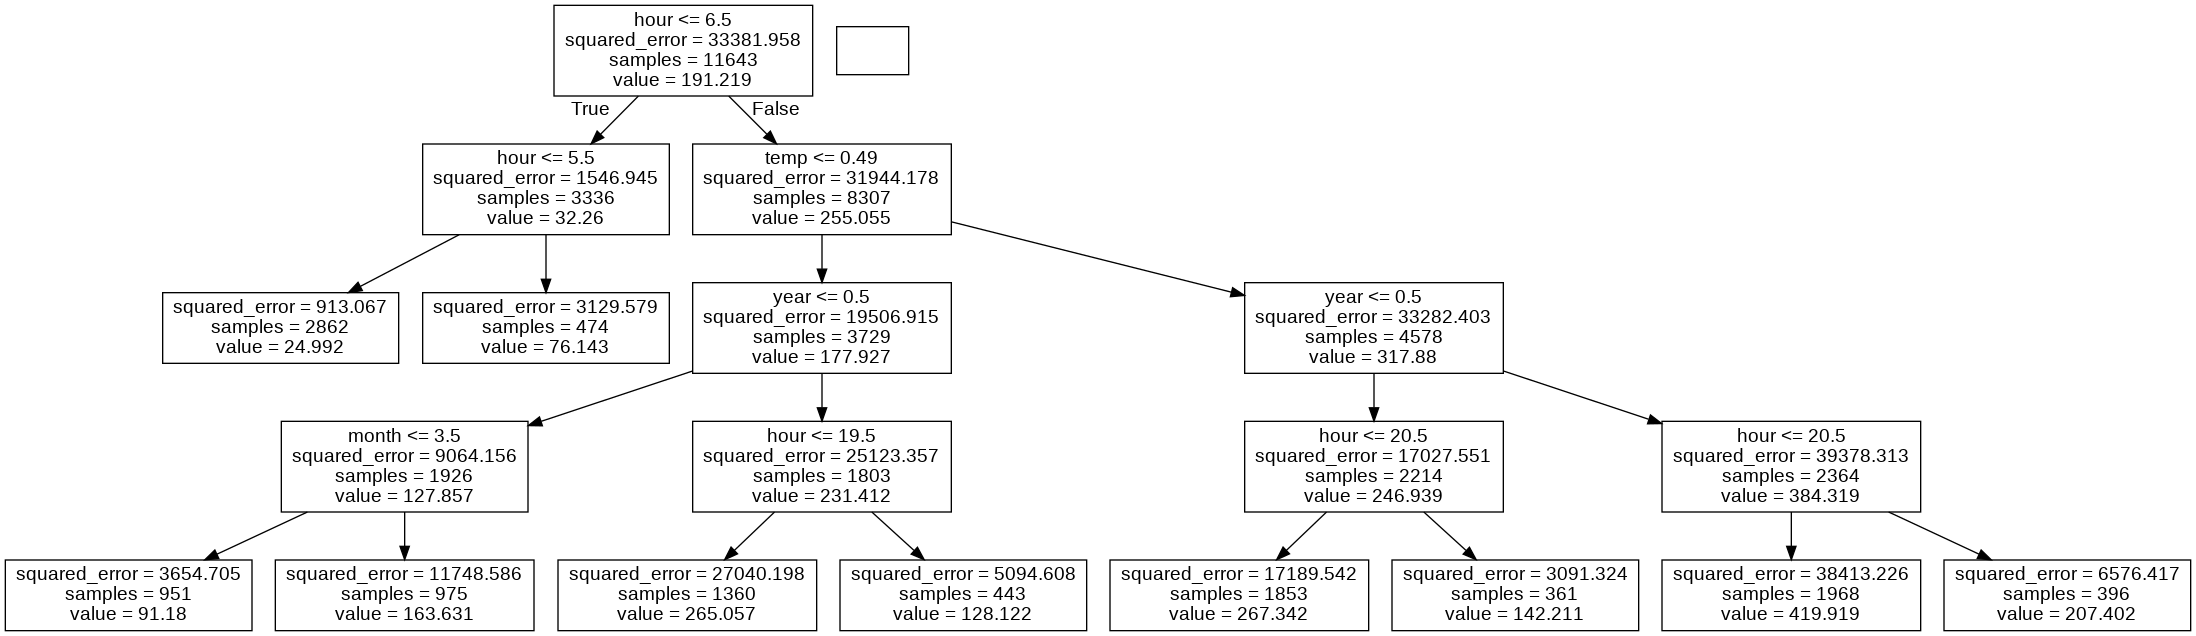

In [101]:
from sklearn import tree
! pip install pydotplus
import pydotplus

from IPython.display import Image

dot_data = tree.export_graphviz(dtr, out_file=None,feature_names=X.columns) 
graph = pydotplus.graph_from_dot_data(dot_data) 

Image(graph.create_png())

### Grid Search con Cross Validation

Ahora empezamos con el proceso de entrenamiento propiamente dicho. Vamos a utilizar validación cruzada. Dado que en el caso de los árboles de decisión también tenemos que preocuparnos por los hiperparámetros, necesitamos un método para ajustarlos.

Hay muchas formas de ajustar los hiperparámetros, las más comunes son grid-search y la búsqueda aleatoria. Como su nombre indica, la búsqueda aleatoria
busca aleatoriamente las combinaciones de hiperparámetros para encontrar la mejor combinación.
Por otro lado, la búsqueda en cuadrícula es un enfoque más sistemático en el que se prueban todas las combinaciones antes de identificar la mejor. 

Para facilitarnos la vida, sklearn proporciona una utilidad para la búsqueda en cuadrícula de los hiperparámetros mientras se valida
el modelo utilizando el método GridSearchCV() del módulo model_selection.

El método GridSearchCV() toma el objeto Regresor/Clasificador como parámetro de entrada junto con un
diccionario de hiperparámetros, el número de validaciones cruzadas requeridas, y algunos más. Utilizamos el siguiente
diccionario para definir nuestra cuadrícula de hiperparámetros.

In [102]:
param_grid = {"criterion": ["squared_error", "absolute_error"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [103]:
from sklearn.model_selection import GridSearchCV

grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

In [104]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [105]:
X.shape

(11643, 19)

In [106]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

El resultado óptimo es:

grid_cv_dtr = DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=500, min_samples_leaf=20, max_depth=10, criterion='mse')

### Cross Validation: Best Model Details

In [107]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))
score=grid_cv_dtr.score(X,y)
print("R-Squared::{}".format(score))

R-Squared::0.8333284746008405
Best Hyperparameters::
{'criterion': 'squared_error', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}
R-Squared::0.8542587156355246


Los resultados son buenos y muestran una mejora espectacular respecto a nuestro modelo de regresión lineal. En primer lugar, vamos a
intentar comprender los resultados del aprendizaje/ajuste del modelo a través de diferentes configuraciones. Para llegar a
diferentes modelos preparados durante nuestra grid-search, utilizamos el atributo cv_results_ del objeto GridSearchCV
El atributo cv_results_ es un array de numpy que podemos convertir fácilmente en un dataframe de pandas.

In [108]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009450,0.001108,0.002151,0.000365,squared_error,2,5,20,10,"{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
1,0.008087,0.000064,0.001837,0.000037,squared_error,2,5,20,20,"{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 20}",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
2,0.008340,0.000154,0.001970,0.000160,squared_error,2,5,20,40,"{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 40}",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
3,0.008251,0.000271,0.001766,0.000228,squared_error,2,5,40,10,"{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 40, 'min_samples_split': 10}",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
4,0.008600,0.001083,0.002679,0.001186,squared_error,2,5,40,20,"{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 40, 'min_samples_split': 20}",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181


Usamos seaborn para visializar el impacto de la profundidad del árbol en la puntuación global
junto con el número de nodos de las hojas. El siguiente fragmento utiliza el mismo marco de datos que preparamos utilizando
cv_results_ del objeto GridSearchCV que hemos comentado anteriormente.

[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

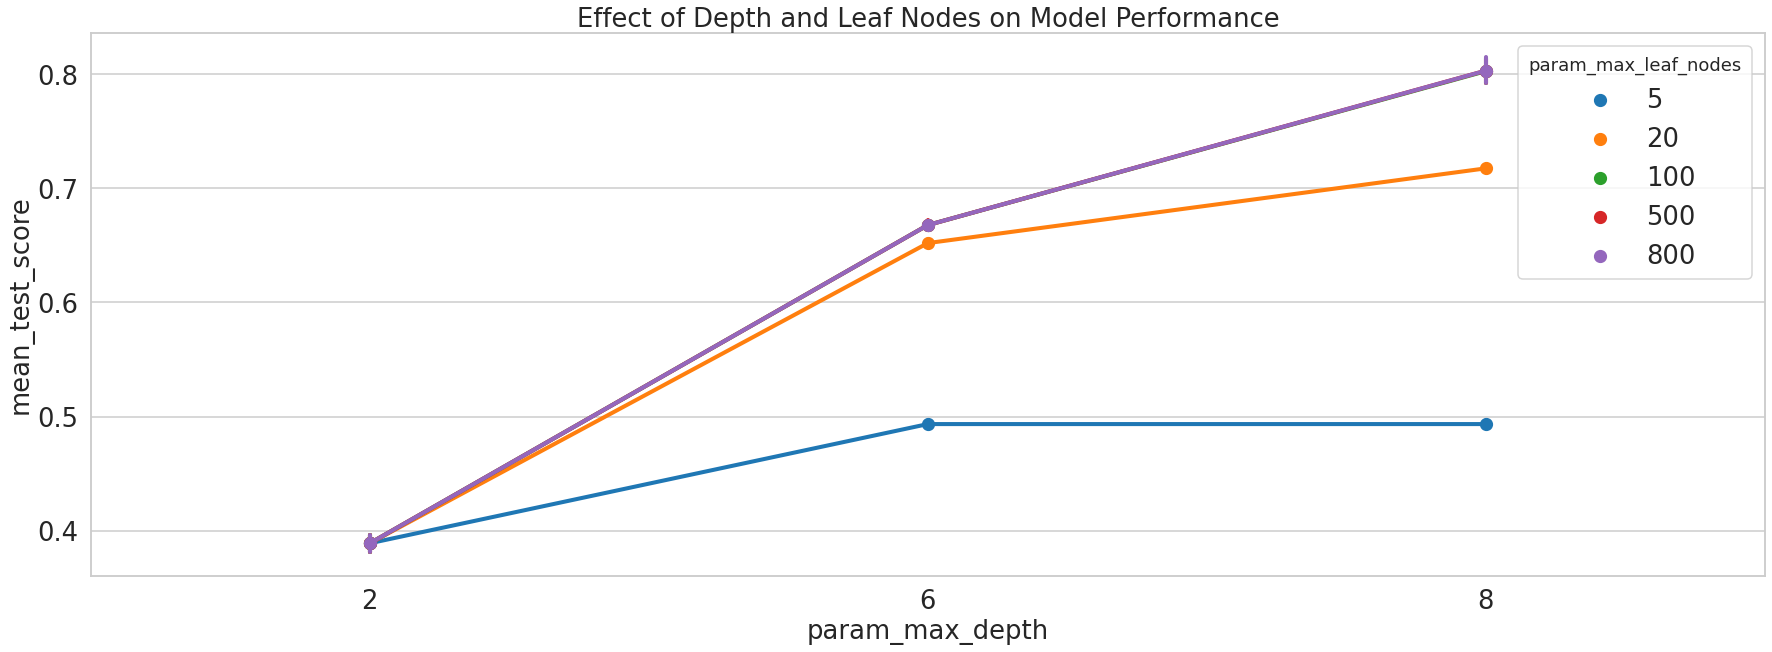

In [109]:
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

### Gráfico de residuos

In [110]:
predicted = grid_cv_dtr.best_estimator_.predict(X)




In [115]:
residuals = y.flatten()-predicted

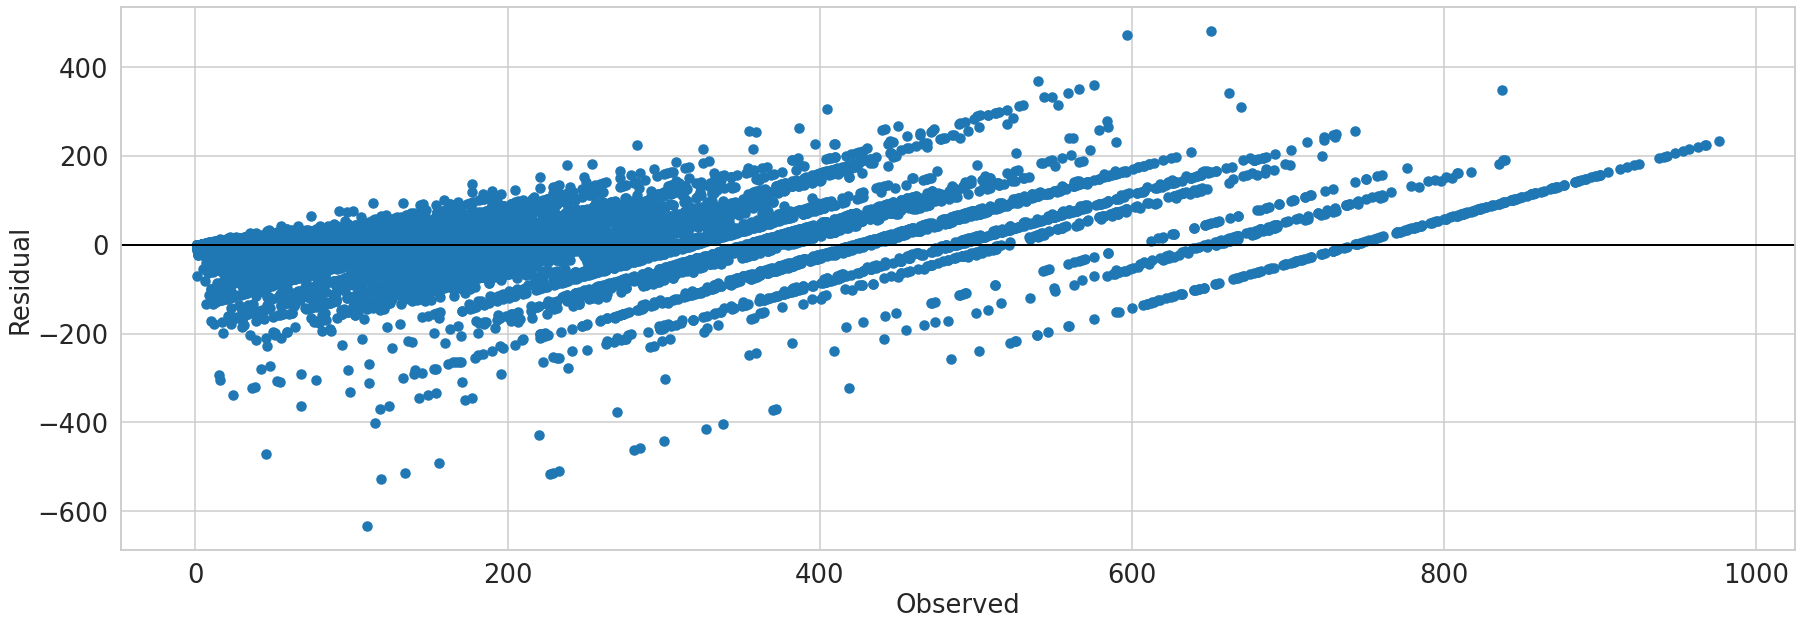

In [117]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

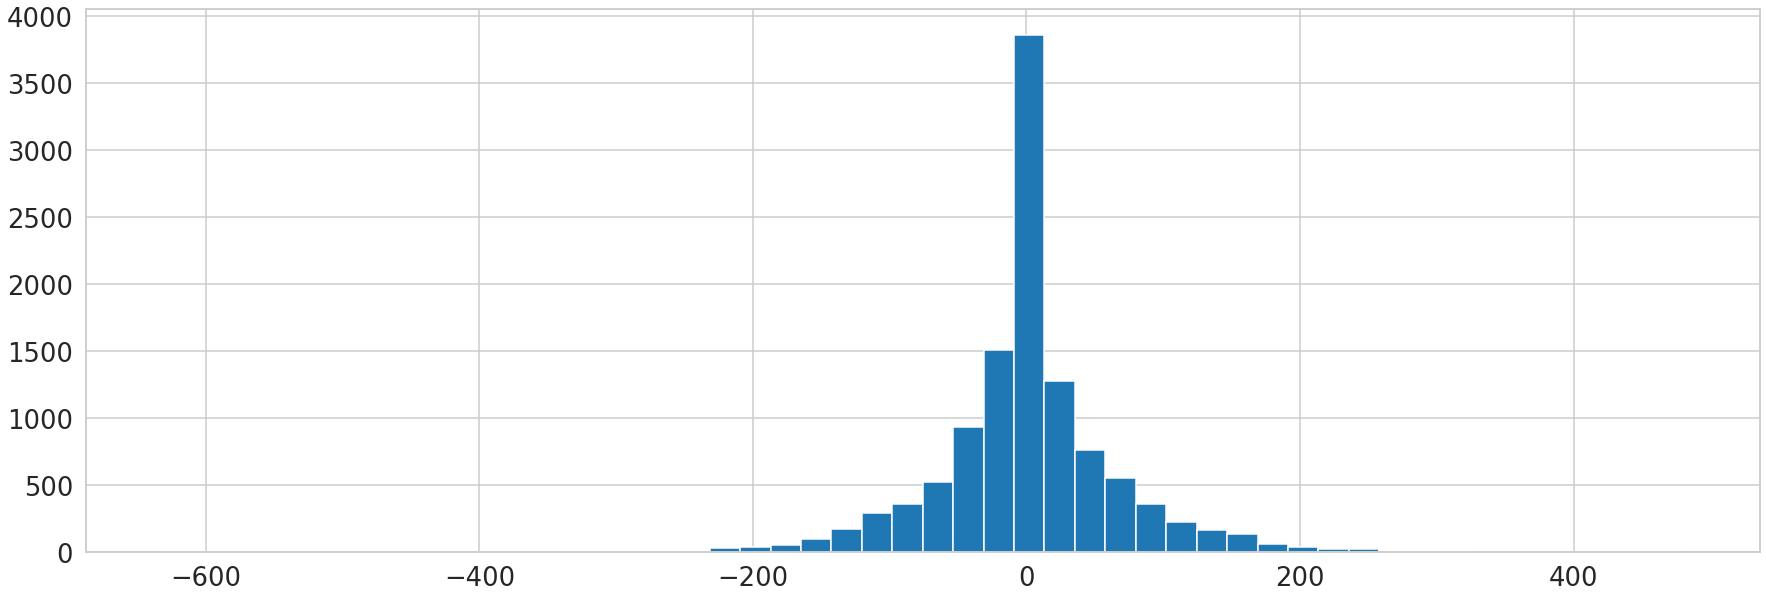

In [118]:
fig, ax = plt.subplots()
ax.hist(residuals,bins=50)
plt.show()

In [120]:
X['residuals'] = residuals

In [122]:
X_wrong = X[X['residuals']>100]

In [83]:
X_wrong

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1,residuals
15,0.40,0.58,0.2985,8,2,3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,213.717172
17,0.36,0.71,0.0000,14,6,12,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,120.123894
19,0.66,0.31,0.1343,17,4,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,109.795556
35,0.78,0.62,0.1343,17,2,8,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,125.795556
40,0.64,0.36,0.2836,18,6,9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,133.268041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0.64,0.36,0.0000,17,6,6,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,105.268041
5667,0.70,0.45,0.2836,14,6,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,121.543478
5694,0.56,0.37,0.1343,15,6,4,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,147.324324
5730,0.38,0.43,0.2239,12,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,139.437500


### Preparando el modelo para test



In [126]:
best_dtr_model = grid_cv_dtr

## Prueba con el set de test

In [129]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in cat_attr_list])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [130]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [131]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [132]:
from sklearn import metrics

r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.8478415542500741
MSE: 4854.08


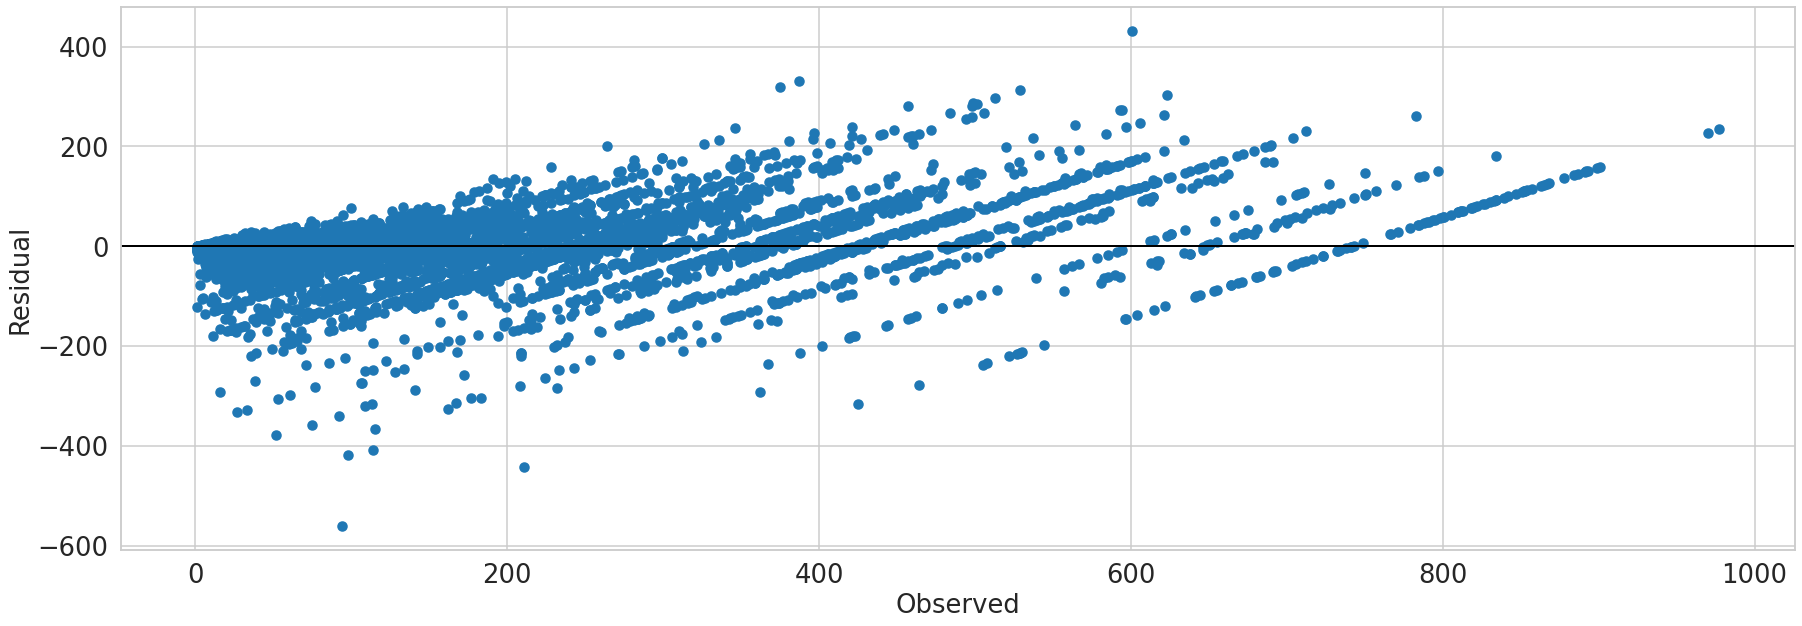

In [133]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)